## HinSage  on Amazon Dataset

In [1]:
%load_ext autoreload
%autoreload 2
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from stellargraph import StellarGraph
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import sys

In [2]:
sys.path.append("/Users/msinghal/SourceCodes/Personal/graphranko/GraphicoRango/steller_graph_implementation")
from datasets import Amz_Dataset
from model import GraphicoRango

In [3]:
??Amz_Dataset

# Load Dataset

In [4]:
dataset = Amz_Dataset()
users, items, edge_ratings = dataset.load(base_path="/Users/msinghal/SourceCodes/Personal/graphranko/Data/amazon-electronics-v2")



Index(['item', 'user', 'rating'], dtype='object')
Index(['user', 'user_id'], dtype='object')


In [5]:
print("number of users {},  number of items {}, number of user item rating {}".format(users.shape, items.shape, edge_ratings.shape))

number of users (100, 1),  number of items (2721, 545), number of user item rating (3112, 550)


In [6]:
edge_ratings.head()

,item,user,rating,user_id,item_id,Wireless Access Points,TV Accessories & Parts,Fans &amp; Cooling,Receivers & Amplifiers,Portable Audio & Video,...,Headsets,Computer & Monitor Mounts,Portable DVD Players,Crossover Parts,Gender Changers,Car Chargers,2 in 1 Laptops,DVD-VCR Combos,Camcorders,Filters
0,7507825604,A108EEYSHGDL6O,5.0,u_36,i_1403,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B000289E4S,A108EEYSHGDL6O,5.0,u_36,i_2647,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,B0002O77T6,A108EEYSHGDL6O,5.0,u_36,i_1766,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B000E43GOO,A108EEYSHGDL6O,5.0,u_36,i_2480,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,B000HHROEQ,A108EEYSHGDL6O,5.0,u_36,i_447,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Split the edge dataset for train and test dataset using sklearn library

In [7]:
from sklearn import model_selection
edges_train, edges_test = model_selection.train_test_split(
    edge_ratings, train_size=0.7, test_size=0.3
)

In [8]:
edgelist_train = list(edges_train[["user_id", "item_id"]].itertuples(index=False))
edgelist_test = list(edges_test[["user_id", "item_id"]].itertuples(index=False))

labels_train = edges_train["rating"]
labels_test = edges_test["rating"]

In [9]:
print("training dataset {}".format(edges_train.shape))
print("test dataset {}".format(edges_test.shape))

training dataset (2178, 550)
test dataset (934, 550)


# Running GraphSage Model without MetaData

## Graph Generation for Graph Neural Network Model

In [10]:
??dataset

In [11]:
graph_with_one_hoting_encoding = dataset.create_graph_for_training(users, items, edge_ratings, metadata=False)

In [12]:
print("--------Numer of Node and edges in Graph -----------")
print("Number of nodes in networkx graph {}, number of eges {}".format(len(graph_with_one_hoting_encoding.nodes()), len(graph_with_one_hoting_encoding.edges())))

--------Numer of Node and edges in Graph -----------
Number of nodes in networkx graph 2821, number of eges 3016


In [13]:
print("---- User Node Features --------")
graph_with_one_hoting_encoding.node_features(node_type = 'user').shape

---- User Node Features --------


(100, 100)

In [14]:
print("---- Item Node Features --------")
graph_with_one_hoting_encoding.node_features(node_type = 'item').shape

---- Item Node Features --------


(2721, 2721)

## Compile GraphicoRango Model

In [15]:
batch_size = 200
epochs = 20
num_samples = [8, 4]
graphicoranko_without_metadata = GraphicoRango(edgelist_train, edgelist_test, labels_train, labels_test, epochs, batch_size, graph_with_one_hoting_encoding, num_samples)

In [16]:
graphicoranko_without_metadata.compile()

{'user': [EdgeType(n1='user', rel='default', n2='item')], 'item': [EdgeType(n1='item', rel='default', n2='user')]}
link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8, 2721)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 32, 100)]    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32, 2721)]   0                                            
__________________________________________________________________________________________

## Train Model

In [17]:
## Before training Model accuracy

test_metrics = graphicoranko_without_metadata.model.evaluate(
    graphicoranko_without_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Untrained model's Test Evaluation:")
for name, val in zip(graphicoranko_without_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 1s 49ms/step - loss: 23.2254 - root_mean_square_error: 4.8206 - mean_absolute_error: 4.7888
Untrained model's Test Evaluation:
	loss: 23.2818
	root_mean_square_error: 4.8291
	mean_absolute_error: 4.7919


In [18]:
history = graphicoranko_without_metadata.train_model()

Epoch 1/20
11/11 [==============================] - 5s 334ms/step - loss: 10.5685 - root_mean_square_error: 3.1479 - mean_absolute_error: 3.1144 - val_loss: 4.6643 - val_root_mean_square_error: 2.1626 - val_mean_absolute_error: 2.1129
Epoch 2/20
11/11 [==============================] - 3s 231ms/step - loss: 2.9528 - root_mean_square_error: 1.6862 - mean_absolute_error: 1.6338 - val_loss: 1.2604 - val_root_mean_square_error: 1.1231 - val_mean_absolute_error: 1.0307
Epoch 3/20
11/11 [==============================] - 3s 234ms/step - loss: 0.7335 - root_mean_square_error: 0.8352 - mean_absolute_error: 0.7565 - val_loss: 0.3196 - val_root_mean_square_error: 0.5541 - val_mean_absolute_error: 0.4998
Epoch 4/20
11/11 [==============================] - 3s 211ms/step - loss: 0.3328 - root_mean_square_error: 0.5667 - mean_absolute_error: 0.3879 - val_loss: 0.3310 - val_root_mean_square_error: 0.5575 - val_mean_absolute_error: 0.3079
Epoch 5/20
11/11 [==============================] - 3s 226ms/st

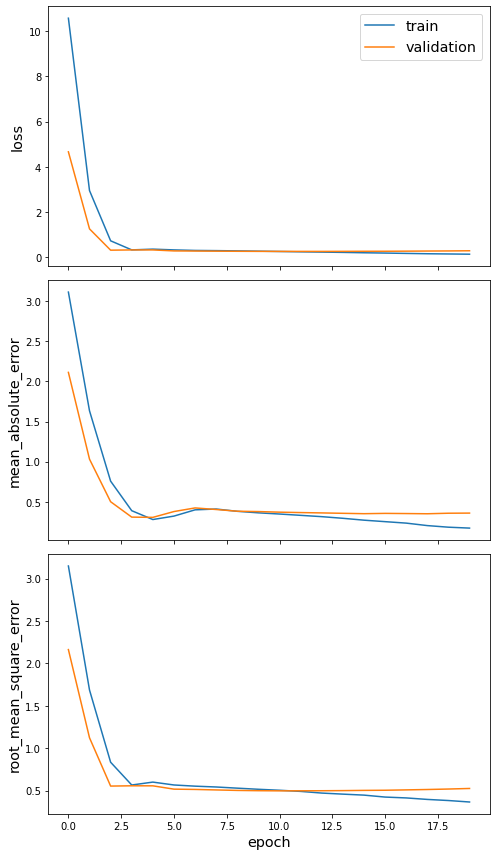

In [19]:
sg.utils.plot_history(history)

In [20]:
## After Model Training Accuracy

test_metrics = graphicoranko_without_metadata.model.evaluate(
    graphicoranko_without_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Trained model's Test Evaluation:")
for name, val in zip(graphicoranko_without_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 1s 129ms/step - loss: 0.2932 - root_mean_square_error: 0.5254 - mean_absolute_error: 0.3575
Trained model's Test Evaluation:
	loss: 0.2932
	root_mean_square_error: 0.5254
	mean_absolute_error: 0.3575


## Model Validation

In [21]:
graphicoranko_without_metadata.validate_model_accuracy()

5/5 [==============================] - 1s 133ms/step - loss: 0.2933 - root_mean_square_error: 0.5263 - mean_absolute_error: 0.3591
Test Evaluation:
	loss: 0.2933
	root_mean_square_error: 0.5263
	mean_absolute_error: 0.3591
Mean Baseline Test set metrics:
	root_mean_square_error =  0.5374945609459483
	mean_absolute_error =  0.41201521650882045

Model Test set metrics:
	root_mean_square_error =  0.5406310491023667
	mean_absolute_error =  0.35885361558109585


In [22]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = graphicoranko_without_metadata.model.predict(graphicoranko_without_metadata.test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, 3)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.8076686512994553
	mean_absolute_error =  1.753747323340471

Model Test set metrics:
	root_mean_square_error =  0.5420614213647242
	mean_absolute_error =  0.35876629822259287


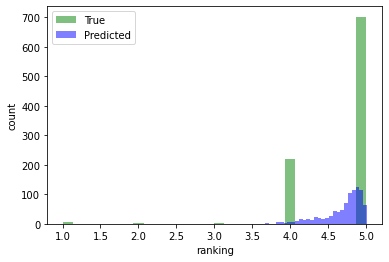

In [23]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [24]:
np.mean(y_true[y_true == 5.0])

5.0

# Running HinSage Model with "category" as metadata 

## Graph Generation for Graph Neural Network Models


In [25]:
graph_with_meta_encoding = dataset.create_graph_for_training(users, items, edge_ratings, metadata=True)


In [26]:
print("--------Numer of Node and edges in Graph -----------")
print("Number of nodes in networkx graph {}, number of eges {}".format(len(graph_with_meta_encoding.nodes()), len(graph_with_meta_encoding.edges())))

--------Numer of Node and edges in Graph -----------
Number of nodes in networkx graph 2821, number of eges 3016


In [27]:
print("---- User Node Features --------")
graph_with_meta_encoding.node_features(node_type = 'user').shape

---- User Node Features --------


(100, 100)

In [28]:
print("---- Item Node Features --------")
graph_with_meta_encoding.node_features(node_type = 'item').shape

---- Item Node Features --------


(2721, 545)

## Compile GraphicoRango Model with Metadata

In [29]:
batch_size = 200
epochs = 20
num_samples = [8, 4]
graphicoranko_with_metadata = GraphicoRango(edgelist_train, edgelist_test, labels_train, labels_test, epochs, batch_size, graph_with_one_hoting_encoding, num_samples)

In [30]:
graphicoranko_with_metadata.compile()

{'user': [EdgeType(n1='user', rel='default', n2='item')], 'item': [EdgeType(n1='item', rel='default', n2='user')]}
link_regression: using 'concat' method to combine node embeddings into edge embeddings
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 8, 2721)]    0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 32, 100)]    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 32, 2721)]   0                                            
________________________________________________________________________________________

## Train Model

In [31]:
## Before training Model accuracy

test_metrics = graphicoranko_with_metadata.model.evaluate(
    graphicoranko_with_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Untrained model's Test Evaluation:")
for name, val in zip(graphicoranko_with_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 1s 51ms/step - loss: 22.0805 - root_mean_square_error: 4.7006 - mean_absolute_error: 4.6683
Untrained model's Test Evaluation:
	loss: 22.1730
	root_mean_square_error: 4.7137
	mean_absolute_error: 4.6756


In [32]:
history = graphicoranko_with_metadata.train_model()

Epoch 1/20
11/11 [==============================] - 5s 302ms/step - loss: 9.7255 - root_mean_square_error: 3.0172 - mean_absolute_error: 2.9839 - val_loss: 4.1920 - val_root_mean_square_error: 2.0502 - val_mean_absolute_error: 1.9993
Epoch 2/20
11/11 [==============================] - 4s 291ms/step - loss: 2.5960 - root_mean_square_error: 1.5822 - mean_absolute_error: 1.5255 - val_loss: 1.0658 - val_root_mean_square_error: 1.0323 - val_mean_absolute_error: 0.9294
Epoch 3/20
11/11 [==============================] - 4s 268ms/step - loss: 0.6287 - root_mean_square_error: 0.7698 - mean_absolute_error: 0.6958 - val_loss: 0.2995 - val_root_mean_square_error: 0.5340 - val_mean_absolute_error: 0.4639
Epoch 4/20
11/11 [==============================] - 3s 252ms/step - loss: 0.3376 - root_mean_square_error: 0.5764 - mean_absolute_error: 0.3615 - val_loss: 0.3427 - val_root_mean_square_error: 0.5674 - val_mean_absolute_error: 0.2938
Epoch 5/20
11/11 [==============================] - 3s 261ms/ste

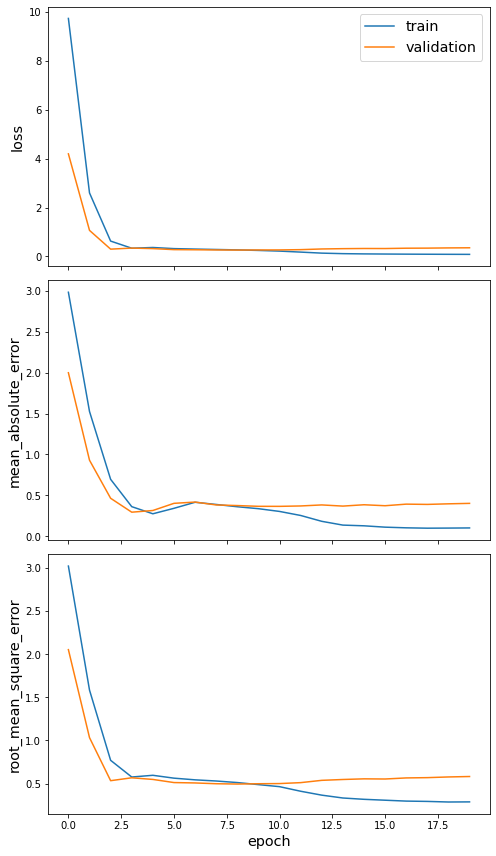

In [33]:
# Print History
sg.utils.plot_history(history)

In [34]:
## After Model Training Accuracy

test_metrics = graphicoranko_with_metadata.model.evaluate(
    graphicoranko_with_metadata.test_gen, verbose=1, use_multiprocessing=False, workers=4
)

print("Trained model's Test Evaluation:")
for name, val in zip(graphicoranko_with_metadata.model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

5/5 [==============================] - 1s 66ms/step - loss: 0.3520 - root_mean_square_error: 0.5800 - mean_absolute_error: 0.4002
Trained model's Test Evaluation:
	loss: 0.3520
	root_mean_square_error: 0.5800
	mean_absolute_error: 0.4002


## Model Validation

In [35]:
graphicoranko_with_metadata.validate_model_accuracy()

5/5 [==============================] - 1s 56ms/step - loss: 0.3542 - root_mean_square_error: 0.5822 - mean_absolute_error: 0.4025
Test Evaluation:
	loss: 0.3542
	root_mean_square_error: 0.5822
	mean_absolute_error: 0.4025
Mean Baseline Test set metrics:
	root_mean_square_error =  0.5374945609459483
	mean_absolute_error =  0.41201521650882045

Model Test set metrics:
	root_mean_square_error =  0.596590010645291
	mean_absolute_error =  0.40335483648026527


In [36]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = graphicoranko_with_metadata.model.predict(graphicoranko_with_metadata.test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, 3)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

Mean Baseline Test set metrics:
	root_mean_square_error =  1.8076686512994553
	mean_absolute_error =  1.753747323340471

Model Test set metrics:
	root_mean_square_error =  0.5957292623105198
	mean_absolute_error =  0.40312618055486577


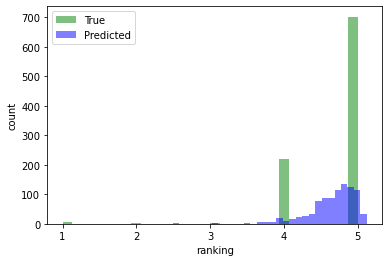

In [37]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("ranking")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()